In [1]:
import matplotlib.pyplot as plt

plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False
import jax
from jax import jit, vmap

from datetime import date

rng_key = jax.random.key(int(date.today().strftime("%Y%m%d")))
from functools import partial
from warnings import filterwarnings

from flax import linen as nn
from flax.linen.initializers import ones
import jax.numpy as jnp
import numpy as np
import tensorflow_probability.substrates.jax.distributions as tfd

from sklearn.datasets import make_moons
from sklearn.preprocessing import scale

import blackjax
from blackjax.vi.svgd import SVGDState

import optax
from jax.flatten_util import ravel_pytree

filterwarnings("ignore")
import matplotlib as mpl

cmap = mpl.colormaps["coolwarm"]

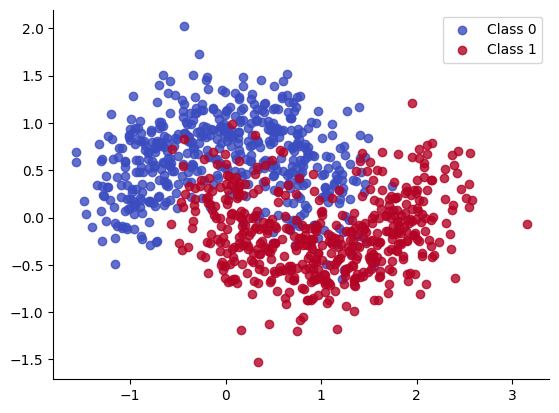

In [2]:
X, Y = make_moons(noise=0.3, n_samples=1000)
for i in range(2):
    plt.scatter(X[Y == i, 0], X[Y == i, 1], color=cmap(float(i)), label=f"Class {i}", alpha=.8)
plt.legend();

In [3]:
n_groups = 18
n_samples = 100
n_grps_sq = int(np.sqrt(n_groups))

def rotate(X, deg):
    theta = np.radians(deg)
    c, s = np.cos(theta), np.sin(theta)
    R = np.matrix([[c, -s], [s, c]])

    X = X.dot(R)

    return np.asarray(X)

In [4]:
np.random.seed(31)

Xs, Ys = [], []
for i in range(n_groups):
    # Generate data with 2 classes that are not linearly separable
    X, Y = make_moons(noise=0.3, n_samples=n_samples)
    X = scale(X)

    # Rotate the points randomly for each category
    rotate_by = np.random.randn() * 90.0
    X = rotate(X, rotate_by)
    Xs.append(X)
    Ys.append(Y)

In [5]:
Xs = jnp.stack(Xs)
Ys = jnp.stack(Ys)

Xs_train = Xs[:, : n_samples // 2, :]
Xs_test = Xs[:, n_samples // 2 :, :]
Ys_train = Ys[:, : n_samples // 2]
Ys_test = Ys[:, n_samples // 2 :]

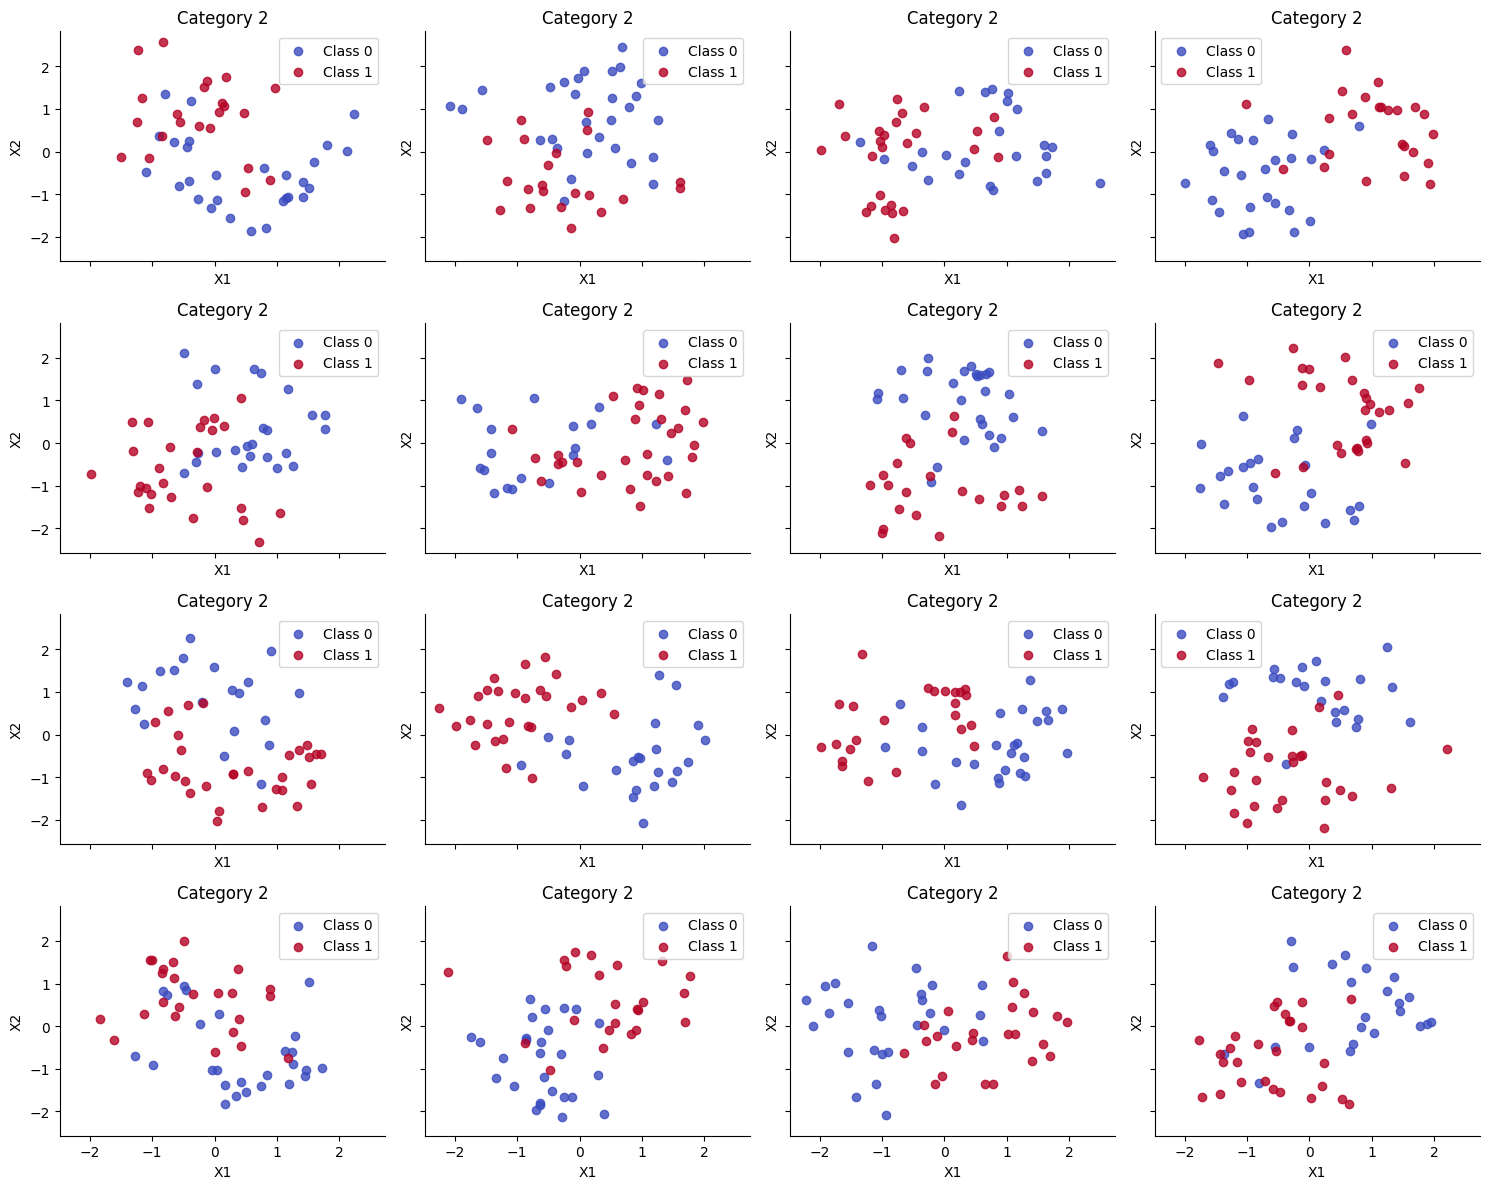

In [6]:
fig, axs = plt.subplots(
    figsize=(15, 12), nrows=n_grps_sq, ncols=n_grps_sq, sharex=True, sharey=True
)
axs = axs.flatten()
for i, (X, Y, ax) in enumerate(zip(Xs_train, Ys_train, axs)):
    for i in range(2):
        ax.scatter(X[Y == i, 0], X[Y == i, 1], color=cmap(float(i)), label=f"Class {i}", alpha=.8)

    ax.legend()
    ax.set(title=f"Category {i + 1}", xlabel="X1", ylabel="X2")


grid = jnp.mgrid[-3:3:100j, -3:3:100j].reshape((2, -1)).T
grid_3d = jnp.repeat(grid[None, ...], n_groups, axis=0)
plt.tight_layout();

In [7]:
def inference_loop(rng_key, step_fn, initial_state, num_samples):
    def one_step(state, rng_key):
        state, _ = step_fn(state)
        return state, state

    keys = jax.random.split(rng_key, num_samples)
    _, states = jax.lax.scan(one_step, initial_state, keys)

    return states

In [8]:
def get_predictions(model, samples, X, rng_key):
    vectorized_apply = jax.vmap(model.apply, in_axes=(0, None), out_axes=0)
    z = vectorized_apply(samples, X)
    predictions = tfd.Bernoulli(logits=z).sample(seed=rng_key)

    return predictions.squeeze(-1)

In [9]:
def get_mean_predictions(predictions, threshold=0.5):
    # compute mean prediction and confidence interval around median
    mean_prediction = jnp.mean(predictions, axis=0)
    return mean_prediction > threshold

In [10]:
# New functions for steinvi:

def svgd_training_loop(
    log_p,
    initial_position,
    initial_kernel_parameters,
    kernel,
    optimizer,
    *,
    num_iterations=500,
):
    svgd = blackjax.svgd(jax.grad(log_p), optimizer, kernel, update_median_heuristic)
    state = svgd.init(initial_position, initial_kernel_parameters)
    step = jax.jit(svgd.step)  # type: ignore[attr-defined]
    for _ in range(num_iterations):
        state = step(state)
    return state

@jit
def rbf_kernel(x, y, length_scale=1):
    arg = ravel_pytree(jax.tree_util.tree_map(lambda x, y: (x - y) ** 2, x, y))[0]
    return jnp.exp(-(1 / length_scale) * arg.sum())

@jit
def median_heuristic(kernel_parameters, particles):
    particle_array = jax.vmap(lambda p: ravel_pytree(p)[0])(particles)

    def distance(x, y):
        return jnp.linalg.norm(jnp.atleast_1d(x - y))

    vmapped_distance = jax.vmap(jax.vmap(distance, (None, 0)), (0, None))
    A = vmapped_distance(particle_array, particle_array)  # Calculate distance matrix
    pairwise_distances = A[
        jnp.tril_indices(A.shape[0], k=-1)
    ]  # Take values below the main diagonal into a vector
    median = jnp.median(pairwise_distances)
    kernel_parameters["length_scale"] = (median**2) / jnp.log(particle_array.shape[0])
    return kernel_parameters


def update_median_heuristic(state: SVGDState) -> SVGDState:
    """Median heuristic for setting the bandwidth of RBF kernels.

    A reasonable middle-ground for choosing the `length_scale` of the RBF kernel
    is to pick the empirical median of the squared distance between particles.
    This strategy is called the median heuristic.
    """

    position, kernel_parameters, opt_state = state
    return SVGDState(position, median_heuristic(kernel_parameters, position), opt_state)

In [11]:
#blackjax.nuts()
# The log-density function we wish to draw samples from
#blackjax.svgd()
# gradient, or an estimate, of the target log density function to samples approximately from

In [12]:
def fit_and_eval(
    rng_key,
    model,
    logdensity_fn,
    X_train,
    Y_train,
    X_test,
    grid,
    n_groups=None,
    num_warmup=1000,
    num_samples=500,
):
    (
        init_key,
        warmup_key,
        inference_key,
        train_key,
        test_key,
        grid_key,
    ) = jax.random.split(rng_key, 6)

    if n_groups is None:
        initial_position = model.init(init_key, jnp.ones(X_train.shape[-1]))
    else:
        initial_position = model.init(init_key, jnp.ones(X_train.shape))
    
    # initialization
    logprob = partial(logdensity_fn, X=X_train, Y=Y_train, model=model)

    #Everything from before:
    # adapt = blackjax.window_adaptation(blackjax.nuts, logprob)
    # (final_state, params), _ = adapt.run(warmup_key, initial_position, num_warmup)
    # step_fn = blackjax.nuts(logprob, **params).step
    # states = inference_loop(inference_key, step_fn, final_state, num_samples)
    # samples = states.position

    # Try to just swap step_fn (desnity has to be the problem, bekomme selben fehler bei beiden)
    num_particles = 100
    initial_particles = (-10) + jax.random.normal(jax.random.PRNGKey(3),shape=(num_particles,))

    svgd = blackjax.svgd(jax.grad(logprob), optax.adam(0.3), rbf_kernel, update_median_heuristic)
    state = svgd.init(initial_particles, median_heuristic({"length_scale": 1}, initial_particles))
    step_fn = jax.jit(svgd.step)
    states = inference_loop(inference_key, step_fn, state, num_samples)
    samples = states.position

    # New inference:
    # num_particles = 100
    # initial_particles = (-10) + jax.random.normal(jax.random.PRNGKey(3),shape=(num_particles,))
    # samples = svgd_training_loop(
    # initial_position = initial_particles,
    # initial_kernel_parameters=median_heuristic({"length_scale": 1}, initial_particles),
    # log_p = logprob,
    # kernel=rbf_kernel,
    # optimizer=optax.adam(0.3),
    # num_iterations=num_samples,
    # )

    # evaluation
    predictions = get_predictions(model, samples, X_train, train_key)
    Y_pred_train = get_mean_predictions(predictions)

    predictions = get_predictions(model, samples, X_test, test_key)
    Y_pred_test = get_mean_predictions(predictions)

    pred_grid = get_predictions(model, samples, grid, grid_key)

    return Y_pred_train, Y_pred_test, pred_grid

# MLP

In [13]:
# MLP params
hidden_layer_width = 5
n_hidden_layers = 2

class NN(nn.Module):
    n_hidden_layers: int
    layer_width: int

    @nn.compact
    def __call__(self, x):
        for i in range(self.n_hidden_layers):
            x = nn.Dense(features=self.layer_width)(x)
            x = nn.tanh(x)
        return nn.Dense(features=1)(x)


bnn = NN(n_hidden_layers, hidden_layer_width)

In [14]:
def logprior_fn(params):
    leaves, _ = jax.tree_util.tree_flatten(params)
    flat_params = jnp.concatenate([jnp.ravel(a) for a in leaves])
    return jnp.sum(tfd.Normal(0, 1).log_prob(flat_params))


def loglikelihood_fn(params, X, Y, model):
    print(params)
    logits = jnp.ravel(model.apply(params, X))
    return jnp.sum(tfd.Bernoulli(logits).log_prob(Y))


def logdensity_fn_of_bnn(params, X, Y, model):
    return logprior_fn(params) + loglikelihood_fn(params, X, Y, model)

In [15]:
#logdensity_fn_of_bnn(params=jnp.asarray([2, 3]),X=Xs_train[1], Y=Ys_train[1], model=bnn)

In [16]:
jnp.ones(Xs_train.shape[-1])

Array([1., 1.], dtype=float32)

In [17]:
initial_position = bnn.init(jax.random.PRNGKey(3), jnp.ones(Xs_train.shape[-1]))
initial_position

{'params': {'Dense_0': {'kernel': Array([[-0.46485624, -0.610228  , -0.18509239,  1.2408992 ,  0.44465777],
          [-0.7554546 , -0.4121815 , -0.7755911 , -0.8719673 ,  0.56295735]],      dtype=float32),
   'bias': Array([0., 0., 0., 0., 0.], dtype=float32)},
  'Dense_1': {'kernel': Array([[ 0.02090942, -0.07558805, -0.5365831 ,  0.326671  , -0.42497823],
          [ 0.25664383, -0.27128446,  0.50611156,  0.00682314,  0.48887092],
          [-0.37986377,  0.4513752 ,  0.05946297,  0.30843756,  0.61649317],
          [ 0.85786873, -0.30301997,  0.4803605 , -0.08204839, -0.19986425],
          [ 0.41545215,  0.28303456, -0.00942245, -0.07373293, -0.10659803]],      dtype=float32),
   'bias': Array([0., 0., 0., 0., 0.], dtype=float32)},
  'Dense_2': {'kernel': Array([[-0.25282907],
          [ 0.08919457],
          [ 0.65764576],
          [ 0.16524062],
          [ 0.429055  ]], dtype=float32),
   'bias': Array([0.], dtype=float32)}}}

In [18]:

logprob = partial(logdensity_fn_of_bnn, X=Xs_train[1], Y=Ys_train[1], model=bnn)
logprob

functools.partial(<function logdensity_fn_of_bnn at 0x000002DAC42C7D30>, X=Array([[ 1.2505574 ,  0.73392713],
       [ 0.07748097,  1.8908483 ],
       [-0.13190553, -1.8054441 ],
       [-0.14458035, -0.64050156],
       [ 0.12585121,  0.5009227 ],
       [ 0.8979951 ,  1.3001932 ],
       [ 0.56579065,  0.09052041],
       [ 1.183313  , -0.13026643],
       [ 0.52179027,  1.8956187 ],
       [ 0.31764767,  0.34069037],
       [ 0.9835738 ,  1.6121148 ],
       [-0.88853794,  0.30163634],
       [-0.47366387,  1.5178286 ],
       [-1.4791855 ,  0.28056356],
       [-0.07869746,  1.3587502 ],
       [ 0.67548174,  2.4532666 ],
       [-1.1546366 , -0.70111024],
       [ 0.09854057,  0.7014625 ],
       [-1.2823615 , -1.3836507 ],
       [ 0.15199131, -1.0247823 ],
       [-0.30417746, -1.2919064 ],
       [-0.5056435 , -0.32346314],
       [ 0.50423384,  0.7345261 ],
       [-0.82222843, -0.86972535],
       [ 0.69518304, -1.1145626 ],
       [-1.8852946 ,  1.009816  ],
       [ 0.5204

In [19]:
rng_key, eval_key = jax.random.split(rng_key)
keys = jax.random.split(eval_key, n_groups)


def fit_and_eval_single_mlp(key, X_train, Y_train, X_test):
    return fit_and_eval(
        key, bnn, logdensity_fn_of_bnn, X_train, Y_train, X_test, grid, n_groups=None
    )

Ys_pred_train, Ys_pred_test, ppc_grid_single = jax.vmap(fit_and_eval_single_mlp)(
    keys, Xs_train, Ys_train, Xs_test
)

Traced<ShapedArray(float32[])>with<JVPTrace(level=7/0)> with
  primal = Traced<ShapedArray(float32[])>with<BatchTrace(level=5/0)> with
    val = Traced<ShapedArray(float32[100])>with<DynamicJaxprTrace(level=3/0)>
    batch_dim = 0
  tangent = Traced<ShapedArray(float32[])>with<JaxprTrace(level=6/0)> with
    pval = (ShapedArray(float32[]), None)
    recipe = LambdaBinding()


TypeError: argument of type 'JVPTracer' is not iterable

In [ ]:
print(f"Train accuracy = {100 * jnp.mean(Ys_pred_train == Ys_train):.2f}%")

Train accuracy = 86.89%


In [ ]:
print(f"Test accuracy = {100 * jnp.mean(Ys_pred_test == Ys_test):.2f}%")

Test accuracy = 82.44%


In [ ]:
def plot_decision_surfaces_non_hierarchical(nrows=2, ncols=2):
    fig, axes = plt.subplots(
        figsize=(15, 12), nrows=nrows, ncols=ncols, sharex=True, sharey=True
    )
    axes = axes.flatten()
    for i, (X, Y_pred, Y_true, ax) in enumerate(
        zip(Xs_train, Ys_pred_train, Ys_train, axes)
    ):
        ax.contourf(
            grid[:, 0].reshape(100, 100),
            grid[:, 1].reshape(100, 100),
            ppc_grid_single[i, ...].mean(axis=0).reshape(100, 100),
            cmap=cmap,
        )
        for i in range(2):
            ax.scatter(
                X[Y_true == i, 0], X[Y_true == i, 1], 
                color=cmap(float(i)), label=f"Class {i}", alpha=.8)
        ax.legend()

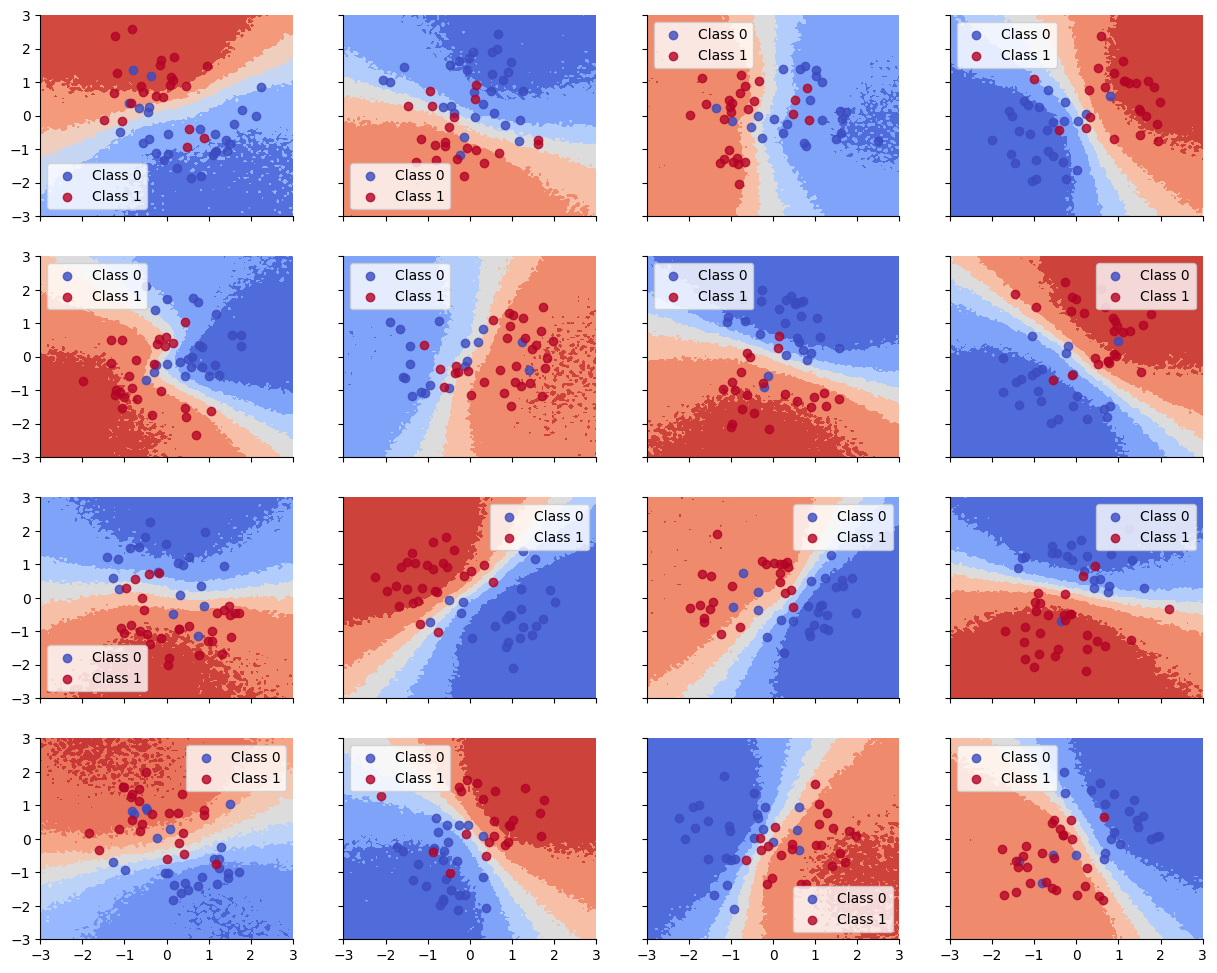

In [ ]:
plot_decision_surfaces_non_hierarchical(nrows=n_grps_sq, ncols=n_grps_sq)